In [1]:
import numpy as np
from pymob import Config
from pymob.inference.scipy_backend import ScipyBackend
from pymob.sim.parameters import Param
from pymob.solvers.diffrax import JaxSolver
from pymob.inference.analysis import plot_pair

In [2]:
# import case study and simulation

config = Config()
config.case_study.package = "../.."
config.case_study.name = "test_case_study"
config.case_study.scenario = "test_hierarchical"
config.case_study.simulation = "HierarchicalSimulation"
config.import_casestudy_modules(reset_path=True)

from test_case_study.sim import HierarchicalSimulation

sim = HierarchicalSimulation(config)
sim.setup()

Inserted './../..' in PATH at index=0
Inserted './../../test_case_study' in PATH at index=0
Results directory exists at '/home/flo-schu/projects/pymob/case_studies/test_case_study/results/test_hierarchical'.
Scenario directory exists at '/home/flo-schu/projects/pymob/case_studies/test_case_study/scenarios/test_hierarchical'.


/home/flo-schu/projects/pymob/pymob/simulation.py:386: UserWarning: The number of ODE states was not specified in the config file [simulation] > 'n_ode_states = <n>'. Extracted the return arguments ['dprey_dt', 'dpredator_dt'] from the source code. Setting 'n_ode_states=2.
  warnings.warn(


## Setting up the data variability structure



In [3]:
sim.config.model_parameters.alpha_species = Param(
    value=0.5, free=True, hyper=True,
    dims=('rabbit_species','experiment'),
    # take good care to specify hyperpriors correctly. 
    # Dimensions are broadcasted following the normal rules of 
    # numpy. The below means, in dimension one, we have two different
    # assumptions 1, and 3. Dimension one is the dimension of the rabbit species.
    # The specification loc=[1,3] would be understood as [[1,3]] and
    # be understood as the experiment dimension. Ideally, the dimensionality
    # is so low that you can be specific about the priors. I.e.:
    # scale = [[1,1,1],[3,3,3]]. This of course expects you know about
    # the dimensionality of the prior (i.e. the unique coordinates of the dimensions)
    prior="norm(loc=[[1],[3]],scale=0.1)" # type: ignore
)
# prey birth rate
# to be clear, this says each replicate has a slightly varying birth
# rate depending on the valley where it was observed. Seems legit.
sim.config.model_parameters.alpha = Param(
    value=0.5, free=True, hyper=False,
    dims=('id',),
    prior="lognorm(s=0.1,scale=alpha_species[rabbit_species_index, experiment_index])" # type: ignore
)

# re initialize the observation with
sim.define_observations_replicated_multi_experiment(n=120) # type: ignore
sim.coordinates["time"] = np.arange(12)
y0 = sim.parse_input("y0", drop_dims=["time"])
sim.model_parameters["y0"] = y0

## Sample from the nested parameter distribution

To simply generate some parameter samples from a distribution, the ScipyBackend has been set up.

In [4]:
inferer = ScipyBackend(simulation=sim)

theta = inferer.sample_distribution()

alpha_samples_cottontail = theta["alpha"][sim.observations["rabbit_species"] == "Cottontail"]
alpha_samples_jackrabbit = theta["alpha"][sim.observations["rabbit_species"] == "Jackrabbit"]

alpha_cottontail = np.mean(alpha_samples_cottontail)
alpha_jackrabbit = np.mean(alpha_samples_jackrabbit)

# test if the priors that were broadcasted to the replicates 
# match the hyperpriors
np.testing.assert_array_almost_equal(
    [alpha_cottontail, alpha_jackrabbit], [1, 3], decimal=1
)

In [23]:
theta

{'alpha_species': array([[1.03455842, 1.08216181, 1.03304371],
        [2.86968428, 3.09053559, 3.04463746]]),
 'alpha': array([0.98047254, 1.09645966, 1.07297153, 1.06544008, 1.03750305,
        1.09269376, 0.96110586, 1.01784098, 0.98586363, 1.0984052 ,
        1.03867608, 1.00474021, 0.95674713, 1.00828963, 1.03540112,
        1.00643501, 1.17748531, 1.14413297, 0.78887961, 0.85647801,
        2.81996594, 2.75105087, 2.93165267, 2.9327314 , 3.54658756,
        2.56767274, 2.76334393, 3.52006402, 3.06139996, 3.06641263,
        2.72590744, 2.43365562, 2.91814602, 2.90113902, 2.53822955,
        2.68016765, 2.84908431, 2.61098319, 2.84162201, 2.89721612,
        1.08601968, 1.02873671, 1.14836079, 1.18302819, 1.11744581,
        0.99714179, 1.16430687, 1.02923594, 1.18160866, 0.97217639,
        1.18578789, 1.0799928 , 0.95512394, 1.04872042, 1.08803242,
        1.11208858, 0.98092616, 0.96872299, 1.10397707, 1.0328126 ,
        3.16418325, 3.33441202, 2.62076345, 3.17016367, 3.493168

Next up we use the samples to generate some trajectories and add Poisson noise on top of the data

In [5]:
sim.solver = JaxSolver
sim.model_parameters["parameters"] = sim.config.model_parameters.value_dict
sim.dispatch_constructor()
e = sim.dispatch(theta=theta)
e()

rng = np.random.default_rng(1)

# add noise. 
obs = e.results
obs.rabbits.values = rng.poisson(e.results.rabbits+1e-6)
obs.wolves.values = rng.poisson(e.results.wolves+1e-6)

# store simulated results
obs.to_netcdf(
    f"{sim.data_path}/simulated_data_hierarchical_species_year.nc"
)

sim.observations = obs
sim.config.data_structure.rabbits.observed = True
sim.config.data_structure.wolves.observed = True

## Defining an incorrect error distribution 💥

To see how to diagnose problems in a model, we deliberately specify an incorrect distribution that looks innocuous, but has two severe problems. One is obvious, the other one is a sneaky one.
Below is a conventionally used way to define error models. We center a lognormal error model around the means of the distribution. 

In [6]:
sim.config.error_model.rabbits = "lognorm(scale=rabbits+EPS, s=0.1)"
sim.config.error_model.wolves = "lognorm(scale=wolves+EPS, s=0.1)"
sim.dispatch_constructor()
sim.set_inferer("numpyro")


First we simply try to fit the distribution, but run into a problem, **because the lognormal distribution does not support zero values**. We get a warning from the `check_log_likelihood` function from the numpyro backend. If we are unsure if our model is specified incorrectly, it is a good idea to use that function.

In [7]:
try:
    sim.inferer.run()
    raise AssertionError(
        "This model should fail, because there are zero values in the"+
        "observations, hence the log-likelihood becomes nan, because there"+
        "is no support for the values"
    )
except RuntimeError:
    # check likelihoods of rabbits     
    loglik = sim.inferer.check_log_likelihood(theta)
    nan_liks = np.isnan(loglik[2]["rabbits_obs"]).sum()
    assert nan_liks > 0


     Trace Shapes:          
      Param Sites:          
     Sample Sites:          
alpha_species dist   2   3 |
             value   2   3 |
        alpha dist     120 |
             value     120 |
         beta dist         |
             value         |
  rabbits_obs dist 120  12 |
             value 120  12 |
   wolves_obs dist 120  12 |
             value 120  12 |


/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:553: UserWarning: Site rabbits_obs: Out-of-support values provided to log prob method. The value argument should be within the support.
  mcmc.run(next(keys))
/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:553: UserWarning: Site wolves_obs: Out-of-support values provided to log prob method. The value argument should be within the support.
  mcmc.run(next(keys))
/home/flo-schu/projects/pymob/pymob/inference/numpyro_backend.py:772: UserWarning: Log-likelihoods ['rabbits_obs', 'wolves_obs'] contained NaN or inf values. The gradient based samplers will not be able to sample from this model. Make sure that all functions are numerically well behaved. Inspect the model with `jax.debug.print('{}',x)` https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html#exploring-debug-callbackOr look at the functions step by step to find the position where jnp.grad(func)(x) evaluates to NaN
  warnings.warn(


This problem can be cured by simply incrementing the observations by a small value, but we can go deeper and investigate if the error model is actually a fitting description of the data. For this we generate some prior predictions to look at further problems in the model

In [8]:
idata = sim.inferer.prior_predictions()

# first we test if numpyro predictions also match the specified priors
alpha_numpyro = idata.prior["alpha"].mean(("chain", "draw"))
alpha_numpyro_cottontail = np.mean(alpha_numpyro.values[sim.observations["rabbit_species"] == "Cottontail"])
alpha_numpyro_jackrabbit = np.mean(alpha_numpyro.values[sim.observations["rabbit_species"] == "Jackrabbit"])

# test if the priors that were broadcasted to the replicates 
# match the hyperpriors
np.testing.assert_array_almost_equal(
    [alpha_numpyro_cottontail, alpha_numpyro_jackrabbit], [1, 3], decimal=1
)

Next we plot the likelihoods of the different data variables. This helps to diagnose problems with multiple endpoints

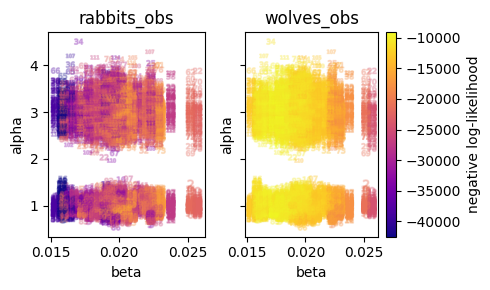

In [9]:
loglik = idata.log_likelihood.sum(("id", "time"))
fig = plot_pair(idata.prior, loglik, parameters=["alpha", "beta"])
fig.savefig(f"{sim.output_path}/bad_likelihood.png")

The problem is: due to the large scale differences in rabbits and wolves, the log-likelihoods end up very differently. This has to do with heteroskedasticity. The lognormal density becomes smaller at larger values to maintain the requirement that probability distributions integrate to 1. Here the wolves data variable will basically be meaningless, because the rabbits data variable is at such a high scale Scaling alone also does not resolve this problem, because due to the dynamic of the data variables, larger values will have a higher weight. This is not right. 🤯

## Defining a correct error distribution for the data by using a residual error model

As it turns out, the residuals of a poisson distributed variable can be transformed to a standard normal distributon by dividing with the square root of the random variables mean. 

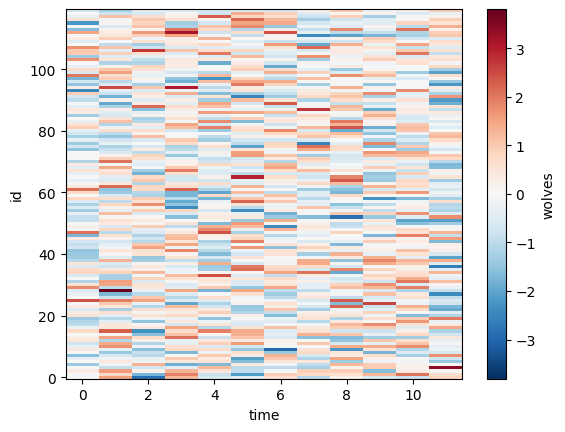

In [10]:
scaled_residuals = (sim.observations - e.results)/np.sqrt(e.results+1e-6)
scaled_residuals.wolves.plot()

The heatmap plot shows us that the residual are equally distributed through time and id. This looks perfect. This means there is no underlying dynamic governing the residuals. In pymob, we specify this relationship **by providing a transform of the observations of our error model**.

In [11]:
sim.config.error_model.rabbits = "norm(loc=0, scale=1, obs=(obs-rabbits)/jnp.sqrt(rabbits+1e-6))"
sim.config.error_model.wolves = "norm(loc=0, scale=1, obs=(obs-wolves)/jnp.sqrt(wolves+1e-6))"

sim.dispatch_constructor()
sim.set_inferer("numpyro")

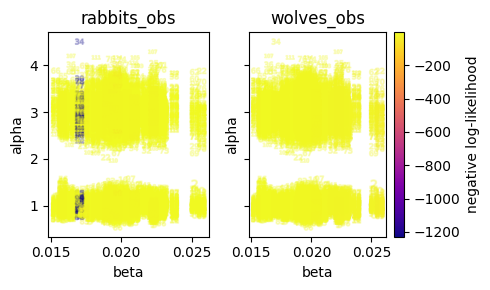

In [12]:
idata = sim.inferer.prior_predictions(n=100)

# no nan problems any longer in the likelihood
loglik = sim.inferer.check_log_likelihood(theta)
nan_liks_rabbits = np.isnan(loglik[2]["rabbits_obs"]).sum()
nan_liks_wolves = np.isnan(loglik[2]["wolves_obs"]).sum()
np.testing.assert_array_equal([nan_liks_wolves, nan_liks_rabbits], [0,0])

# plot likelihoods
loglik = idata.log_likelihood.mean(("id", "time"))
fig = plot_pair(idata.prior, loglik, parameters=["alpha", "beta"])
fig.savefig(f"{sim.output_path}/good_likelihood.png")

Next we look at the problem from a slightly different angle. By splitting the likelihood between different ids (in case of a hierarchical model this is possible, we can look at problematic samples.)

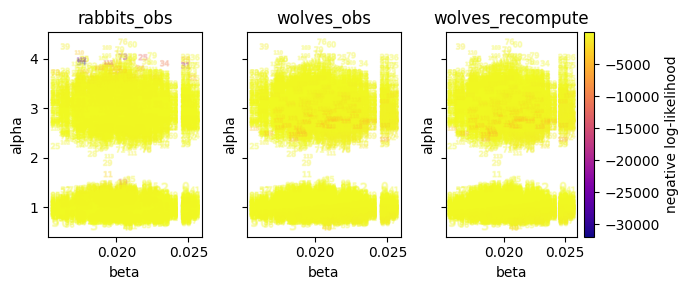

In [13]:
from scipy.stats import norm

# the 2nd visualization is actually not so helpful, because it rather focuses on
# the individual replicates and not so much on the dynamics of the parameters

idata = sim.inferer.prior_predictions(n=100, seed=132)

resid = (idata.prior_predictive.wolves - idata.observed_data.wolves)/np.sqrt(idata.prior_predictive.wolves)
loglik = norm(0,1).logpdf(resid)

idata.log_likelihood.wolves_obs
idata.log_likelihood["wolves_recompute"] = (("chain", "draw","id", "time"), loglik)

loglik = idata.log_likelihood.sum(("time"))
prior = idata.prior.rename({"alpha_dim_0":"id"})
fig = plot_pair(prior, loglik, parameters=["alpha", "beta"])
fig.savefig(f"{sim.output_path}/better_likelihood_questionmark.png")

Overall we conclude that it is way better to use residuals for the error modelling, because if the residuals are described correctly, this results in an equally distributed likelihood of the errorrs.

In addition, the reparameterization of the error distribution has seemed to help the NUTS sampler.

In [16]:
# fitting with SVI seems to work okay
sim.config.inference_numpyro.kernel = "nuts"
sim.config.inference_numpyro.svi_iterations = 2_000
sim.config.inference_numpyro.svi_learning_rate = 0.005
sim.config.inference_numpyro.gaussian_base_distribution = True
sim.config.jaxsolver.max_steps = 1e5
sim.config.jaxsolver.throw_exception = False
sim.config.inference_numpyro.init_strategy = "init_to_median"
sim.dispatch_constructor()
sim.set_inferer("numpyro")
sim.inferer.run()
sim.inferer.store_results() # type: ignore

                 Trace Shapes:          
                  Param Sites:          
                 Sample Sites:          
alpha_species_normal_base dist   2   3 |
                         value   2   3 |
        alpha_normal_base dist     120 |
                         value     120 |
         beta_normal_base dist         |
                         value         |
              rabbits_obs dist 120  12 |
                         value 120  12 |
               wolves_obs dist 120  12 |
                         value 120  12 |


sample: 100%|██████████| 3000/3000 [32:02<00:00,  1.56it/s, 15 steps of size 3.81e-01. acc. prob=0.87]   



                                    mean       std    median      5.0%     95.0%     n_eff     r_hat
          alpha_normal_base[0]     -0.44      0.27     -0.43     -0.89     -0.01   3284.77      1.00
          alpha_normal_base[1]      0.75      0.26      0.75      0.30      1.14   3710.04      1.00
          alpha_normal_base[2]      0.19      0.28      0.20     -0.25      0.64   3194.97      1.00
          alpha_normal_base[3]      0.44      0.28      0.44     -0.05      0.86   3560.29      1.00
          alpha_normal_base[4]      0.15      0.26      0.16     -0.28      0.58   3944.40      1.00
          alpha_normal_base[5]      0.75      0.26      0.75      0.35      1.18   3418.16      1.00
          alpha_normal_base[6]     -0.44      0.28     -0.44     -0.89      0.01   3511.33      1.00
          alpha_normal_base[7]      0.03      0.31      0.03     -0.50      0.52   3287.28      1.00
          alpha_normal_base[8]     -0.10      0.26     -0.10     -0.55      0.30   3346.33

array([[<Axes: title={'center': 'alpha_species'}>,
        <Axes: title={'center': 'alpha_species'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

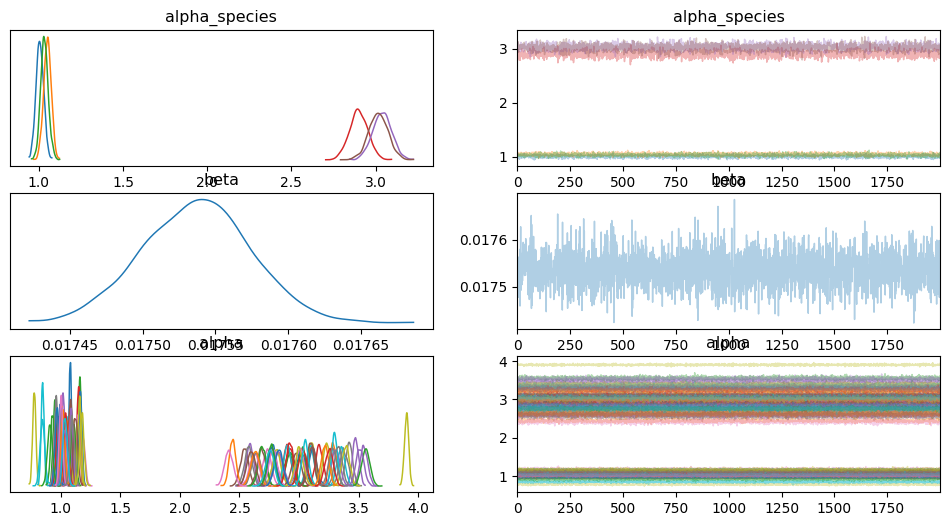

In [22]:
import arviz as az

az.plot_trace(sim.inferer.idata, var_names=("alpha_species", "beta", "alpha"))

The parameters are perfectly recovered. We have a true beta of 0.1765 and the fitted beta is 0.1755, where the distribution contains the true parameter, although the mode is a bit off. I'm curious if the residual error distribution was too wide or too narrow would have made the posterior beta distribution wider. Also in a second iteration, the priors for estimating should be made less informative, to see if the inference still works. But overall this has been a success. We have no divergences, perfect r_hat and high effective sampling size. So things look good

In [25]:
theta["beta"]

array([[1.03455842, 1.08216181, 1.03304371],
       [2.86968428, 3.09053559, 3.04463746]])

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

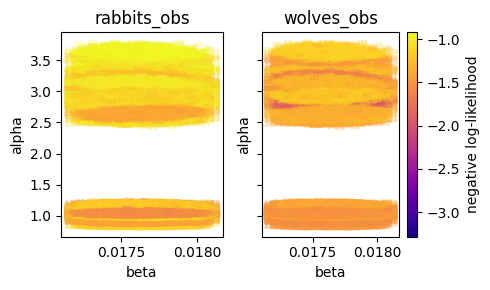

In [21]:

# posterior = sim.inferer.idata.posterior.rename({"alpha_dim_0":"id"})
loglik = sim.inferer.idata.log_likelihood.mean(("time"))
fig = plot_pair(posterior, loglik, parameters=["alpha", "beta"])
fig.savefig(f"{sim.output_path}/posterior.png")
